## Library imports and global variables setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from matplotlib import rcParams

inference_data_path = "./inference_data"
gt_data_path = "./gt_data"

objects_names = ["adjustable_wrench","apple","a_toy_airplane","banana","baseball","bleach_cleanser","bowl","b_toy_airplane","cracker_box","gelatin_box","hammer","lemon","master_chef_can",
                 "mug","mustard_bottle","orange","phillips_screwdriver","pitcher_base","plate","potted_meat_can","power_drill","pudding_box","rubiks_cube","scissors","strawberry",
                 "sugar_box","tennis_ball","tomato_soup_can","tuna_fish_can", "wood_block"]

inference_objects_folders_name = [name for name in os.listdir(inference_data_path) if os.path.isdir(os.path.join(inference_data_path, name))]
inference_objects_folders_name = sorted(inference_objects_folders_name, key=int)

metrics_dictionary = {}

## Helper functions

In [2]:
def perfrom_rmse(image_1, image_2):
    """
    Function to compute the Root Mean squared error between to input images
    """
    return np.sqrt(np.mean((image_1-image_2)**2))

def perform_iou(image_1, image_2):
    """
    Function to compute the Intersection over unit between to input images
    """
    intersection = np.logical_and(image_1, image_2)
    union = np.logical_or(image_1, image_2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

## Main code

The following block of code loads every heightmap and contact mask image from the ground trught, the predictions done by the custom FCRN network and the standard methods. For each image RMSE and IOU metrics are computed and stored

In [7]:
### Iterate per each object in the dataset
for folder_name in inference_objects_folders_name:
    inference_folder_path = f"{inference_data_path}/{folder_name}/"
    gt_folder_path = f"{gt_data_path}/{folder_name}/"

    ### Go inside first folder for both folders
    entries_per_folder = len([name for name in os.listdir(f"{gt_folder_path}/contact_mask/")])
    metrics_dictionary[folder_name] = [[],[],[],[]]

    for file_index in range(entries_per_folder // 2):
        ### Load gt contact mask and hieght mapnumber index
        gt_contact_mask = np.load(f"{gt_folder_path}contact_mask/{file_index}.npy")
        inference_contact_mask = np.load(f"{inference_folder_path}contact_mask/{file_index}.npy")
        threhsold_contact_mask = np.load(f"{inference_folder_path}contact_mask/{file_index}_threhsold.npy")
        threhsold_contact_mask = threhsold_contact_mask[:,:,0]
        
        gt_height_map = np.load(f"{gt_folder_path}height_map/{file_index}.npy")
        inference_height_map = np.load(f"{inference_folder_path}height_map/{file_index}.npy")
        lookup_height_map = np.load(f"{inference_folder_path}height_map/{file_index}_lookup.npy")

        ### Perform RMSE and IOU
        height_map_rmse = perfrom_rmse(inference_height_map, gt_height_map)
        contact_mask_iou = perform_iou(inference_contact_mask, gt_contact_mask)
        
        lookup_height_map_rmse = perfrom_rmse(lookup_height_map, gt_height_map)
        threhsold_contact_mask_iou = perform_iou(threhsold_contact_mask, gt_contact_mask)
        
        ### Store
        metrics_dictionary[folder_name][0].append(height_map_rmse)
        metrics_dictionary[folder_name][1].append(contact_mask_iou)     
        
        metrics_dictionary[folder_name][2].append(lookup_height_map_rmse)
        metrics_dictionary[folder_name][3].append(threhsold_contact_mask_iou)

## Results analysis

The following block of code, parses the information extracted fomr the images metrics in order to prepare it for an easier visualization. Then box plots are constructed using the parsed information in order to visually analyse the results.

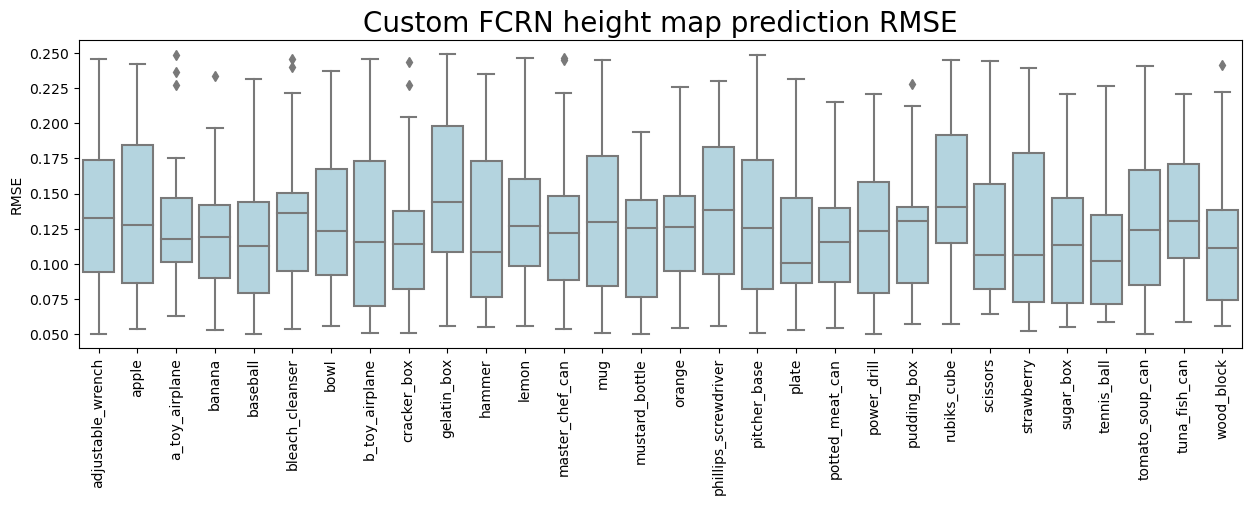

In [36]:
metrics_dataframe = pd.DataFrame(metrics_dictionary.values(), columns=['RMSE', 'IOU','RMSE_lookup', 'IOU_threhsold'], index=objects_names)

total_rmse_arrays = []
total_iou_arrays = []
total_rmse_lookup_arrays = []
total_iou_threhsold_arrays = []

for index, row in metrics_dataframe.iterrows():
    total_rmse_arrays.append(row['RMSE'])
    total_iou_arrays.append(row['IOU'])
    total_rmse_lookup_arrays.append(row['RMSE_lookup'])
    total_iou_threhsold_arrays.append(row['IOU_threhsold'])
rcParams['figure.figsize'] = 15,4

ax = sns.boxplot(data=total_rmse_arrays, color="lightblue")
ax.set_ylabel('RMSE')
plt.xticks(rotation=90)
plt.title("Custom FCRN height map prediction RMSE", fontsize=20) 

_ = ax.set_xticklabels(objects_names)
plt.savefig('custom_FCRN_height_map_prediction_RMSE.png',bbox_inches = "tight")

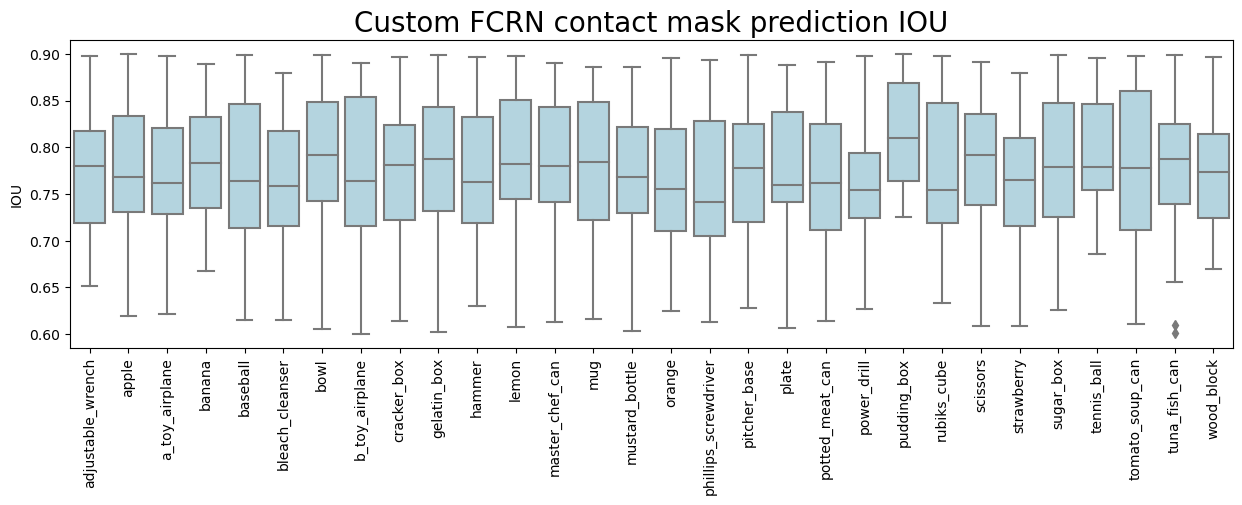

In [37]:
ax = sns.boxplot(data=total_iou_arrays, color="lightblue")
ax.set_ylabel('IOU')
plt.xticks(rotation=90)
plt.title("Custom FCRN contact mask prediction IOU", fontsize=20) 

# Set ticks labels for x-axis
_ = ax.set_xticklabels(objects_names)
plt.savefig('custom_FCRN_contact_mask_prediction_IOU.png',bbox_inches = "tight")

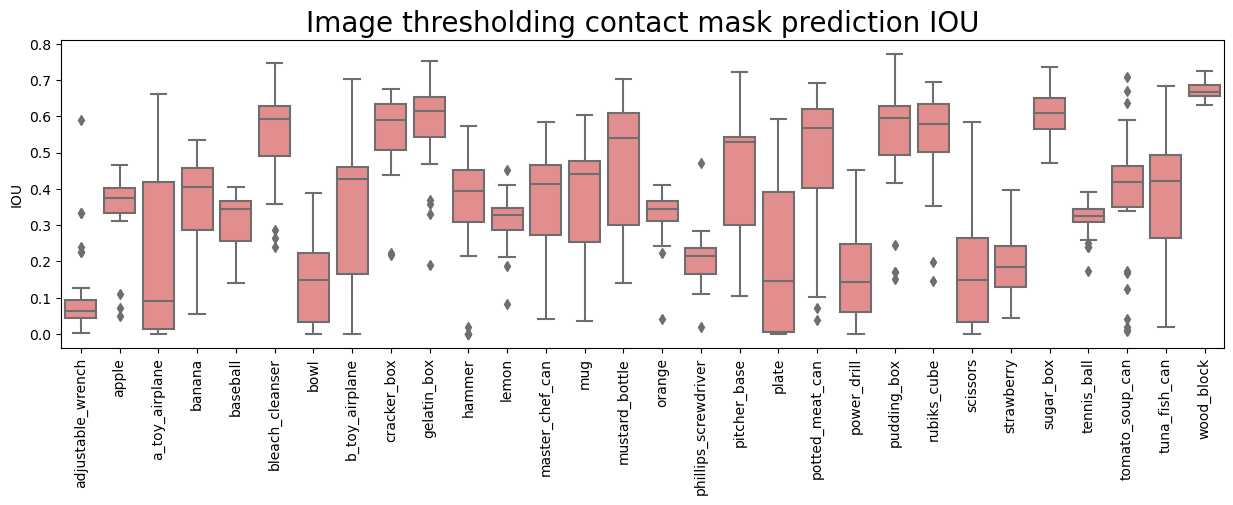

In [38]:
ax = sns.boxplot(data=total_iou_threhsold_arrays, color="lightcoral")
ax.set_ylabel('IOU')
plt.xticks(rotation=90)
plt.title("Image thresholding contact mask prediction IOU", fontsize=20) 

# Set ticks labels for x-axis
_ = ax.set_xticklabels(objects_names)
plt.savefig('image_thresholding_contact_mask_prediction_IOU.png',bbox_inches = "tight")

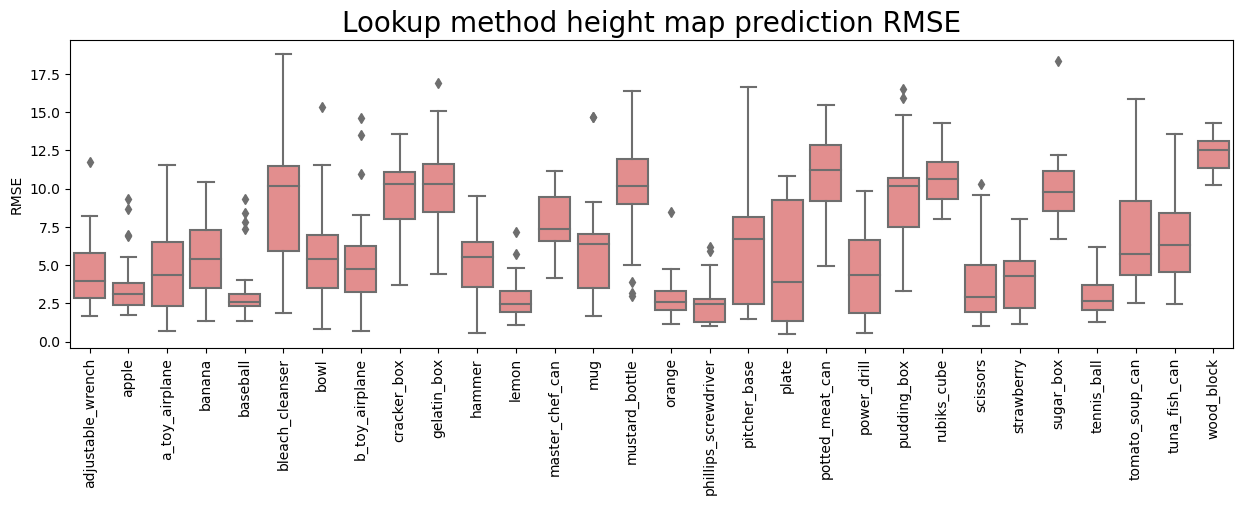

In [39]:
ax = sns.boxplot(data=total_rmse_lookup_arrays, color="lightcoral")
ax.set_ylabel('RMSE')
plt.xticks(rotation=90)
plt.title("Lookup method height map prediction RMSE", fontsize=20) 

# Set ticks labels for x-axis
_ = ax.set_xticklabels(objects_names)
plt.savefig('lookup_method_height_map_prediction_RMSE.png',bbox_inches = "tight")